# Customer Segmentation on E - commerce datasets using RFM Analysis

### Datasets

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### Overview

**Goal** :  Increase revenue by leveraging customer base on transaction behavior and purchasing history.

**Research Question** : How to find lever from customer transaction behavior and purchasing history to increase revenue?

# 1. Load Dependencies and Configuration Settings

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")


from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Helper

In [17]:
# Print a title in red with borders
def title(text):
    RED = '\033[91m'
    END = '\033[0m'
    up =  '╭' + '━'*(len(text)+2) + '╮'
    mid = '│ ' + text + ' │'
    down = '╰' + '━'*(len(text)+2) + '╯'
    print()
    print(RED + up + END)
    print(RED + mid + END)
    print(RED + down + END)
    print()

# Percentage formating in pie charts
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%'.format(p=pct,v=val)
    return my_autopct

# Manage colors
%matplotlib inline
sns.set_style('whitegrid')
color = sns.color_palette()

# 2. Load Datasets

In [3]:
# Load the file
df = pd.read_csv('/Users/hayaayu/Users/hayaayu/Self Development/Data Science/Dibimbing/Finpro/data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
title("Number of samples")
print(len(df))
title("Number of duplicates")
print(df.duplicated().sum())
title("Missing values")
print(df.isna().sum())
title("Data types")
print(df.dtypes)
title("Check random raw samples")
df.sample(5, random_state=0)


╭━━━━━━━━━━━━━━━━━━━╮
│ Number of samples │
╰━━━━━━━━━━━━━━━━━━━╯

541909

╭━━━━━━━━━━━━━━━━━━━━━━╮
│ Number of duplicates │
╰━━━━━━━━━━━━━━━━━━━━━━╯

5268

╭━━━━━━━━━━━━━━━━╮
│ Missing values │
╰━━━━━━━━━━━━━━━━╯

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

╭━━━━━━━━━━━━╮
│ Data types │
╰━━━━━━━━━━━━╯

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

╭━━━━━━━━━━━━━━━━━━━━━━━━━━╮
│ Check random raw samples │
╰━━━━━━━━━━━━━━━━━━━━━━━━━━╯



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
387967,570410,22396,MAGNETS PACK OF 4 RETRO PHOTO,1,10/10/2011 13:04,0.39,16776,United Kingdom
510721,579467,23560,SET OF 6 RIBBONS COUNTRY STYLE,6,11/29/2011 14:57,2.89,15755,United Kingdom
416072,572550,23567,EGG CUP HENRIETTA HEN PINK,1,10/24/2011 17:06,2.46,NaN,United Kingdom
437992,574301,20749,ASSORTED COLOUR MINI CASES,4,11/3/2011 16:15,7.95,12544,Spain
166468,550921,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,4/21/2011 14:21,0.55,14770,United Kingdom


**Insights**

- We must drop the duplicated raws.
- There are missing values in the Description and CustomerID columns. We will drop the raws.
- We should convert the InvoiceDate column into datetime data type and CustomerID into string data type.

**Other points needing to be checked**

- Minimums of the numerical features Quantity and UnitPrice ? Does it make sense for the column ?
- What are there maximums ? Are there outliers ?

In [4]:
#statistics descriptive of numerical data
num_cols = ['Quantity', 'UnitPrice']
for col in num_cols:
    title(col + " statistics")
    print(df[col].describe())


╭━━━━━━━━━━━━━━━━━━━━━╮
│ Quantity statistics │
╰━━━━━━━━━━━━━━━━━━━━━╯

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

╭━━━━━━━━━━━━━━━━━━━━━━╮
│ UnitPrice statistics │
╰━━━━━━━━━━━━━━━━━━━━━━╯

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64


**Insights**

- There are negative values for both Quantity and UnitPrice that will to be removed. 
- These values likely correspond to returned items, and our focus will be on analyzing customer purchasing behavior.
- The maximum values are significantly higher than the mean and standard deviation. 
- For the sake of simplicity, we will exclude the outliers from our analysis. 
- They might correspond to small items that are bought in large quantity (nails, paper bags...) or other expensive products (machines). In both cases, they are quite specific.

# 3. Data Preprocessing

In [5]:
#Renaming columns

df.rename(columns={"InvoiceNo":"invoice_num", 
                   "StockCode":"stock_code", 
                  "Description":"description", 
                  "Quantity":"quantity", 
                  "InvoiceDate":"invoice_date", 
                  "UnitPrice":"unit_price", 
                  "CustomerID":"customer_id", 
                  "Country":"country"}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_num   541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  object 
 7   country       541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


The column related to the transaction date will be converted from 'object' (a simple string basically) to the very convenient date format "date-time" in pandas.

In [6]:
#transform invoice date
df['invoice_date']=pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_num   541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  object        
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


## 3.1 Missing Data Handling

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_num   541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  object        
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


There are some null values for description and customer id.
In particular the exact number of missing values in each column is:

In [8]:
df.isnull().sum().sort_values(ascending=False)

customer_id     135080
description       1454
invoice_num          0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
country              0
dtype: int64

The portion of dataframe where some values are missing is the following:

In [9]:
df_miss=df[df.isnull().any(axis=1)]
df_miss.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


**Is there any relationship between the missing data?**

In [10]:
df_miss.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [11]:
df_miss["day"] = df_miss['invoice_date'].map(lambda x: x.day)
df_miss["month"] = df_miss['invoice_date'].map(lambda x: x.month)
df_miss["year"] = df_miss['invoice_date'].map(lambda x: x.year)

In [12]:
df_miss['daymonth']=df_miss['day'].astype(str)+'/'+df_miss['month'].astype(str)
df_miss['daymonthyear']=df_miss['daymonth'].astype(str)+'/'+df_miss['year'].astype(str)
df_miss['monthyear']=df_miss['month'].astype(str)+'/'+df_miss['year'].astype(str)

In [13]:
df_miss.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,day,month,year,daymonth,daymonthyear,monthyear
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,1,12,2010,1/12,1/12/2010,12/2010
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1,12,2010,1/12,1/12/2010,12/2010
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1,12,2010,1/12,1/12/2010,12/2010
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,1,12,2010,1/12,1/12/2010,12/2010
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,1,12,2010,1/12,1/12/2010,12/2010


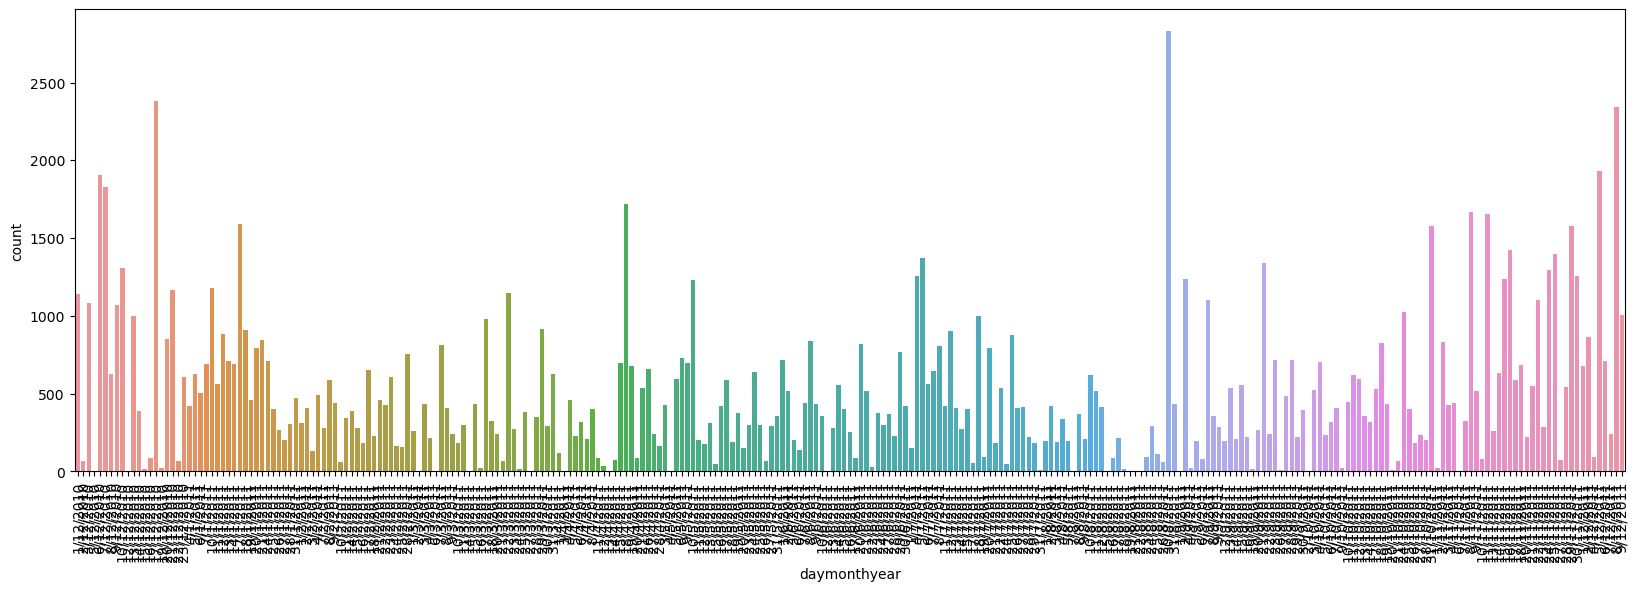

In [14]:
fig, ax = plt.subplots(figsize=(20,6)) 
ax = sns.countplot(x='daymonthyear', data=df_miss)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

This plot looks messy, but its clear that during some days there have been more missing values than others.
In particular the days with most missing values are:

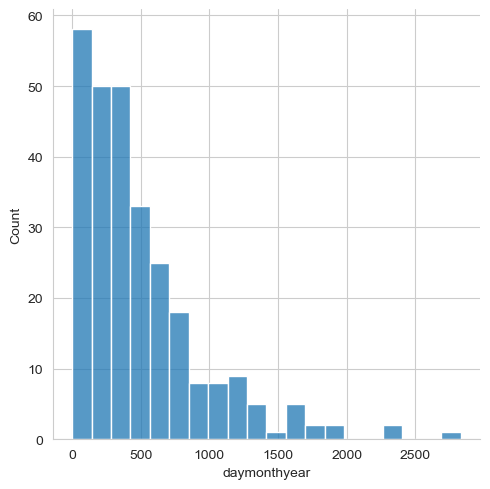

In [18]:
sns.displot(df_miss['daymonthyear'].value_counts())

We can see that during some days, more than 2500 customers_id are missing. We will now check the days where most cusomers id are missing.

For further analysis, the rows with missing values will be dropped and a new df called 'df_new' will be defined.

In [20]:
df_new=df.dropna()

In [21]:
#check if there a are missing values in the new dataframe
df_new.isnull().sum().sort_values(ascending=False)

invoice_num     0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [22]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_num   406829 non-null  object        
 1   stock_code    406829 non-null  object        
 2   description   406829 non-null  object        
 3   quantity      406829 non-null  int64         
 4   invoice_date  406829 non-null  datetime64[ns]
 5   unit_price    406829 non-null  float64       
 6   customer_id   406829 non-null  object        
 7   country       406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


## 3.2 Duplicated Value Handling

In [23]:
df_new[df_new.duplicated()].head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom


In [24]:
df_new.duplicated().sum()

5225

There are 5225 duplicated transactions
These transaction will be dropped from the dataset.

In [26]:
df_new.drop_duplicates(inplace=True)

In [27]:
df_new.duplicated().sum()

0

## 3.3 Change Column Type

In [28]:
df_new['customer_id']=df_new.customer_id.astype('int64')

In [29]:
df_new.describe()

,quantity,unit_price,customer_id
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Quantity has negative values and unit price has a minimum value of 0. 

In [30]:
np.sum(df_new['quantity'] < 0)

8872

There are 8872 transactions with negative quantity. We will investigate if they are related to canceled orders or mistakes.

## 3.4 Canceled Order Analysis

In [31]:
canceled_orders = df_new[df_new['invoice_num'].apply(lambda x: x[0]=='C')]
canceled_orders.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


By analyzing the first 5 values of the dataframe we can see that the quantity has a negative values, is this true for all canceled orders?

In [32]:
(canceled_orders['quantity'] < 0).sum()

8872

Yes, as expetcted all the transactions with negative values are canceled orders.

In [34]:
print('The percentage of canceled orders is: {} %'.format(round(canceled_orders.shape[0]/df_new.shape[0]*100,2)))

The percentage of canceled orders is: 2.21 %


Now, all the canceled orders will be dropped

In [35]:
df_new = df_new[df_new['quantity'] > 0]
df_new.sort_values(by='stock_code', ascending=False, inplace=True)
df_new.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299512,563100,POST,POSTAGE,6,2011-08-12 09:57:00,40.0,12381,Norway
224432,556526,POST,POSTAGE,1,2011-06-13 11:33:00,18.0,12732,France
186640,552874,POST,POSTAGE,7,2011-05-12 09:40:00,18.0,12621,Germany
103055,545051,POST,POSTAGE,1,2011-02-27 11:58:00,18.0,12599,France
477044,577046,POST,POSTAGE,7,2011-11-17 13:46:00,18.0,12449,Belgium


In [36]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 299512 to 30249
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_num   392732 non-null  object        
 1   stock_code    392732 non-null  object        
 2   description   392732 non-null  object        
 3   quantity      392732 non-null  int64         
 4   invoice_date  392732 non-null  datetime64[ns]
 5   unit_price    392732 non-null  float64       
 6   customer_id   392732 non-null  int64         
 7   country       392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


# 4. Feature Engineering

We will add a column 'Amount spent'.

In [42]:
df_new['amount_spent']=df_new['quantity'] * df_new['unit_price']

In [43]:
df_new.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,amount_spent
299512,563100,POST,POSTAGE,6,2011-08-12 09:57:00,40.0,12381,Norway,240.0
224432,556526,POST,POSTAGE,1,2011-06-13 11:33:00,18.0,12732,France,18.0
186640,552874,POST,POSTAGE,7,2011-05-12 09:40:00,18.0,12621,Germany,126.0
103055,545051,POST,POSTAGE,1,2011-02-27 11:58:00,18.0,12599,France,18.0
477044,577046,POST,POSTAGE,7,2011-11-17 13:46:00,18.0,12449,Belgium,126.0


We will create columns for day, month, year.

In [44]:
df_new.insert(loc=2, column='yearmonth', value=df_new['invoice_date'].map(lambda x: 100 * x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.invoice_date.dt.month)
df_new.insert(loc=4, column='day', value=(df_new.invoice_date.dt.dayofweek) + 
              1) # +1 is used to make Monday=1.....until Sunday=7
df_new.insert(loc=5, column='hour', value=df_new.invoice_date.dt.hour)

In [45]:
df_new.head()

,invoice_num,stock_code,yearmonth,month,day,hour,description,quantity,invoice_date,unit_price,customer_id,country,amount_spent
299512,563100,POST,201108,8,5,9,POSTAGE,6,2011-08-12 09:57:00,40.0,12381,Norway,240.0
224432,556526,POST,201106,6,1,11,POSTAGE,1,2011-06-13 11:33:00,18.0,12732,France,18.0
186640,552874,POST,201105,5,4,9,POSTAGE,7,2011-05-12 09:40:00,18.0,12621,Germany,126.0
103055,545051,POST,201102,2,7,11,POSTAGE,1,2011-02-27 11:58:00,18.0,12599,France,18.0
477044,577046,POST,201111,11,4,13,POSTAGE,7,2011-11-17 13:46:00,18.0,12449,Belgium,126.0


Now the dataset looks cleaner and is ready for EDA.

# 5. Exploratory Data Analysis

## How many orders by customer?

In [37]:
orders=df_new.groupby(by=['customer_id','country'], as_index=False)['invoice_num'].count()
orders.head()

,customer_id,country,invoice_num
0,12346,United Kingdom,1
1,12347,Iceland,182
2,12348,Finland,31
3,12349,Italy,73
4,12350,Norway,17


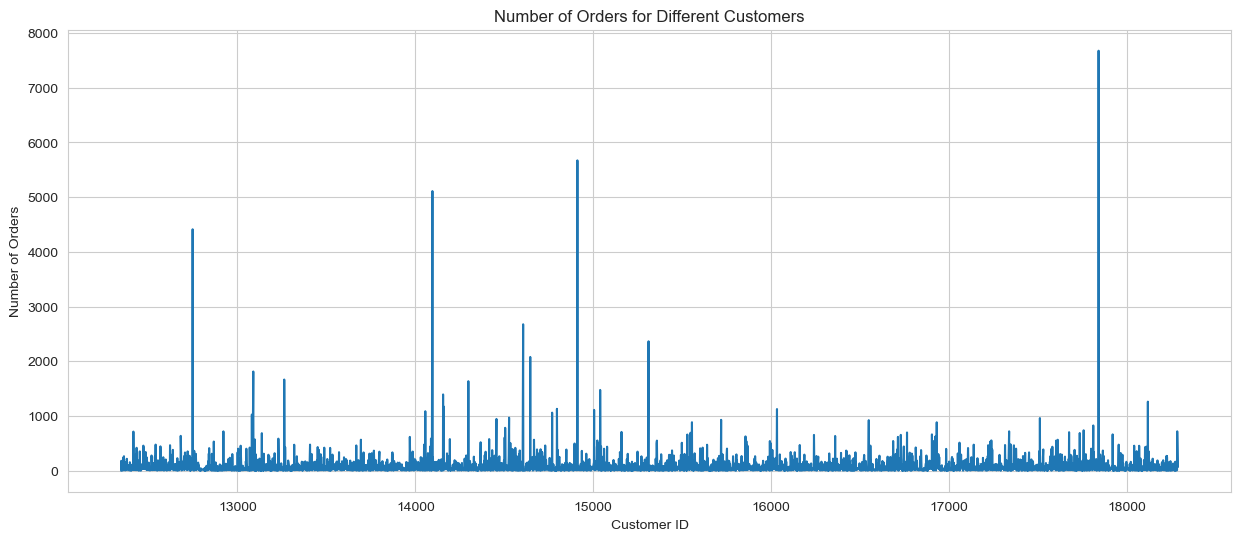

In [38]:
plt.subplots(figsize=(15,6))
plt.plot(orders.customer_id, orders.invoice_num)
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for Different Customers')
plt.show()

### Top 5 Numbers of Orders:

In [39]:
orders.sort_values(by='invoice_num', ascending=False).head()

,customer_id,country,invoice_num
4019,17841,United Kingdom,7676
1888,14911,EIRE,5672
1298,14096,United Kingdom,5111
334,12748,United Kingdom,4413
1670,14606,United Kingdom,2677


The customer with the highest number of orders comes from the United Kingdom (UK)

## How much money spent by customers?

In [47]:
money_spent = df_new.groupby(by=['customer_id','country'], as_index=False)['amount_spent'].sum()
money_spent.head()

,customer_id,country,amount_spent
0,12346,United Kingdom,77183.60
1,12347,Iceland,4310.00
2,12348,Finland,1797.24
3,12349,Italy,1757.55
4,12350,Norway,334.40


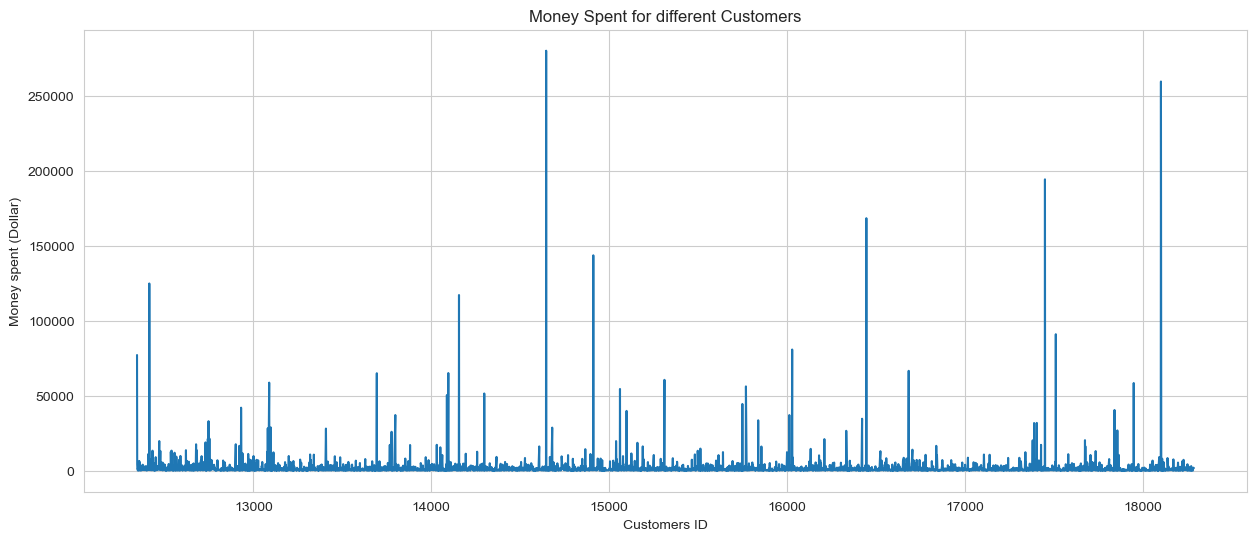

In [48]:
plt.subplots(figsize=(15,6))
plt.plot(money_spent.customer_id, money_spent.amount_spent)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

The customer with the highest money spent on purchases comes from Netherlands.

## Do some customers have higher average transaction values or quantities than others?

             avgCustomerPrice  avgCustomerQuantity
customer_id                                       
12346            77183.600000         74215.000000
12747               40.737961            12.378641
12748                7.489959             5.730342
12749               20.557186             7.391960
12820               15.971864            12.237288


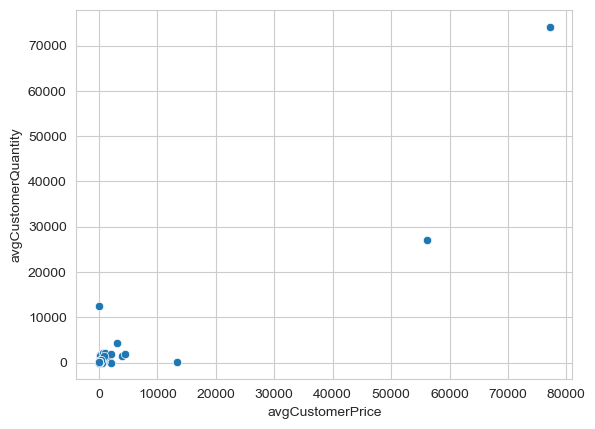

In [70]:
# We can answer this question by grouping the data by customer and calculating the mean for the 'TotalPrice' and 'Quantity' columns
mean_price_by_customer = df_new.groupby('customer_id')['amount_spent'].mean()
mean_quantity_by_customer = df_new.groupby('customer_id')['quantity'].mean()

# Now, we'll put the num_customers_by_year_and_country and retention_rate_by_year_and_country data into a single dataframe
df_avgtranq = pd.concat([mean_price_by_customer, mean_quantity_by_customer], axis=1)
df_avgtranq.columns = ['avgCustomerPrice', 'avgCustomerQuantity']

print(df_avgtranq.head())
sns.scatterplot(x='avgCustomerPrice', y='avgCustomerQuantity', data=df_avgtranq)
plt.show()

### Top 5 Highest Spent

In [49]:
money_spent.sort_values(by='amount_spent', ascending=False).head()

,customer_id,country,amount_spent
1698,14646,Netherlands,280206.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194390.79
3017,16446,United Kingdom,168472.50
1888,14911,EIRE,143711.17


## How many orders per Years?

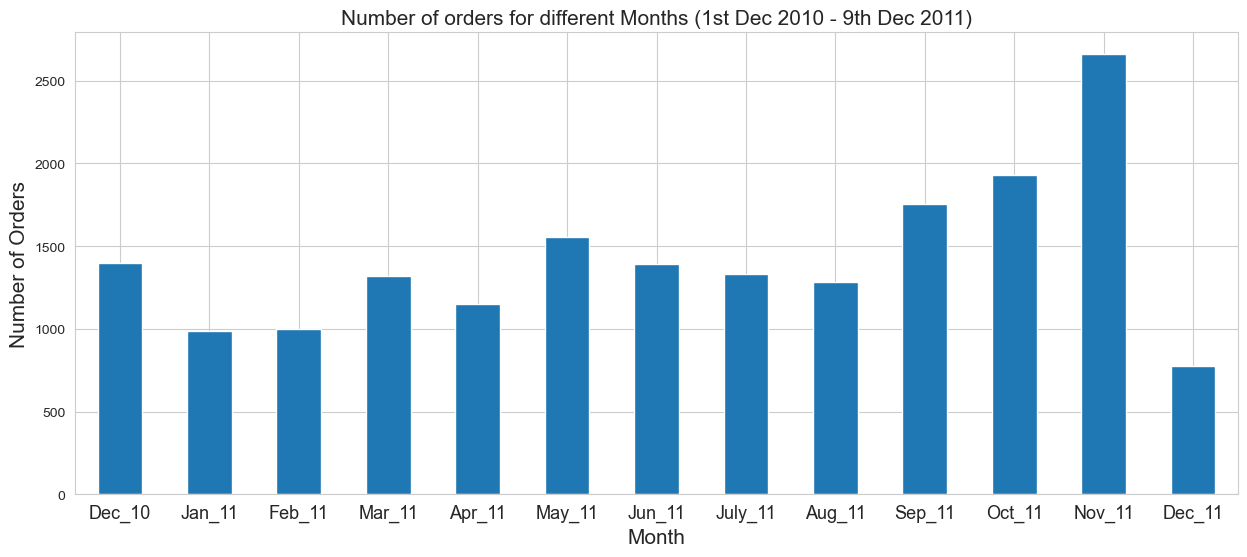

In [51]:
ax = df_new.groupby('invoice_num')['yearmonth'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

November looks like the month with most orders.

## How many orders per Day?

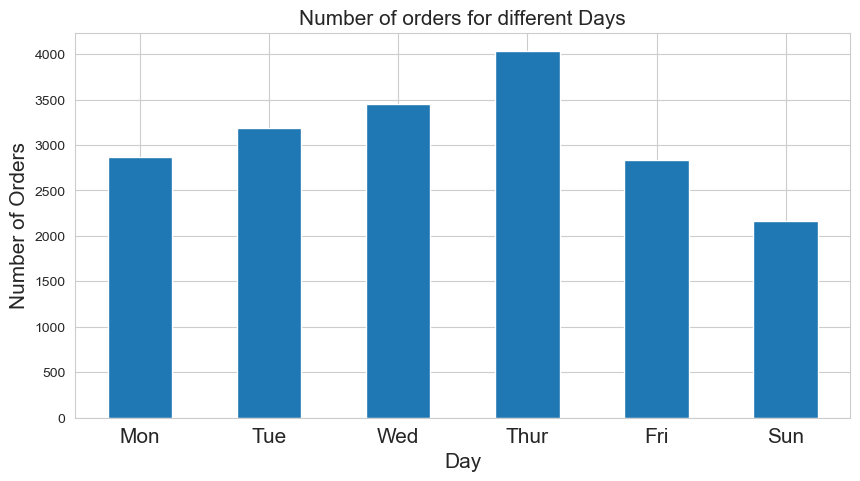

In [53]:
ax = df_new.groupby('invoice_num')['day'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(10,5))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

It looks like Thursday is the day with most orders.

## How's the pattern for Unit Price?

In [54]:
df_new.unit_price.describe()

count    392732.000000
mean          3.125596
std          22.240725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: unit_price, dtype: float64

There are orders with 0 unit price (free items).

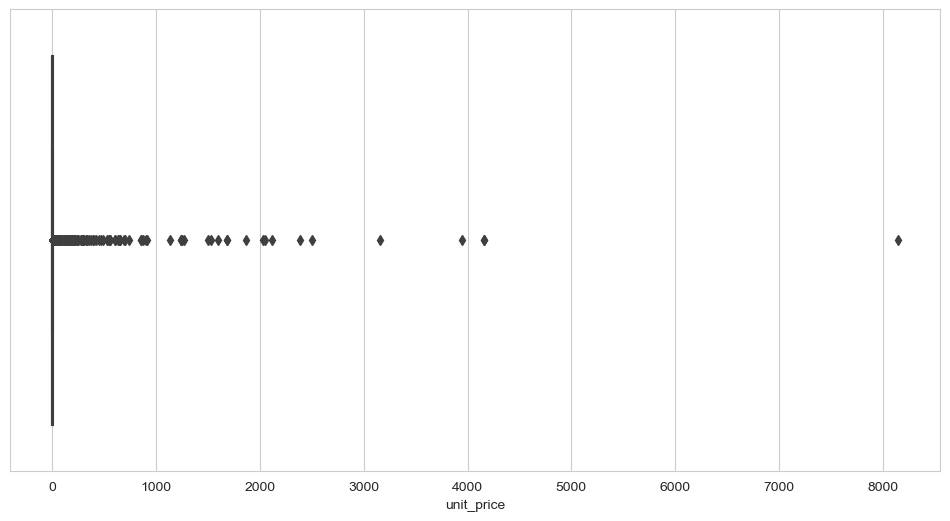

In [55]:
plt.subplots(figsize=(12,6))
sns.boxplot(df_new.unit_price)
plt.show()

It looks like the majority of products have unit_price lower than 10. We will use 10 as a threshold value to deeper explore the unit_price.

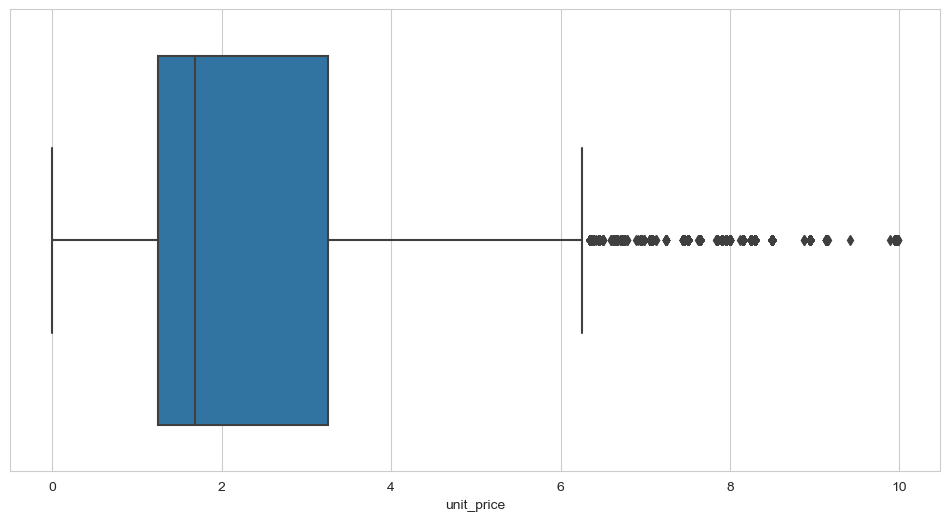

In [56]:
plt.subplots(figsize=(12,6))
sns.boxplot(df_new[df_new['unit_price'] < 10].unit_price)
plt.show()

In [57]:
df_free=df_new[df_new['unit_price'] == 0]
df_free.head()

,invoice_num,stock_code,yearmonth,month,day,hour,description,quantity,invoice_date,unit_price,customer_id,country,amount_spent
358655,568158,PADS,201109,9,7,12,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.0,16133,United Kingdom,0.0
436961,574252,M,201111,11,4,13,Manual,1,2011-11-03 13:24:00,0.0,12437,France,0.0
485985,577696,M,201111,11,1,11,Manual,1,2011-11-21 11:57:00,0.0,16406,United Kingdom,0.0
361825,568384,M,201109,9,2,9,Manual,1,2011-09-27 09:46:00,0.0,12748,United Kingdom,0.0
479546,577168,M,201111,11,5,10,Manual,1,2011-11-18 10:42:00,0.0,12603,Germany,0.0


## How many free items are sold on each month?

In [58]:
df_free.yearmonth.value_counts().sort_index()

201012     3
201101     3
201102     1
201103     2
201104     2
201105     2
201107     2
201108     6
201109     2
201110     3
201111    14
Name: yearmonth, dtype: int64

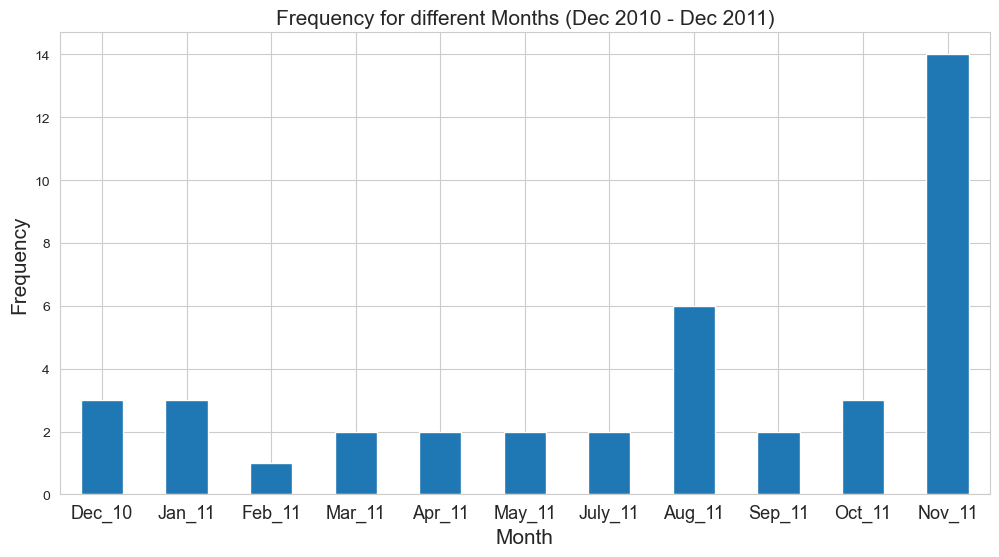

In [60]:
ax = df_free.yearmonth.value_counts().sort_index().plot(kind='bar',figsize=(12,6), color=color[0])
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()

On average, we see that the companies give 2 items for free each month. No free items were given on June 2011.

## How many orders for each country?

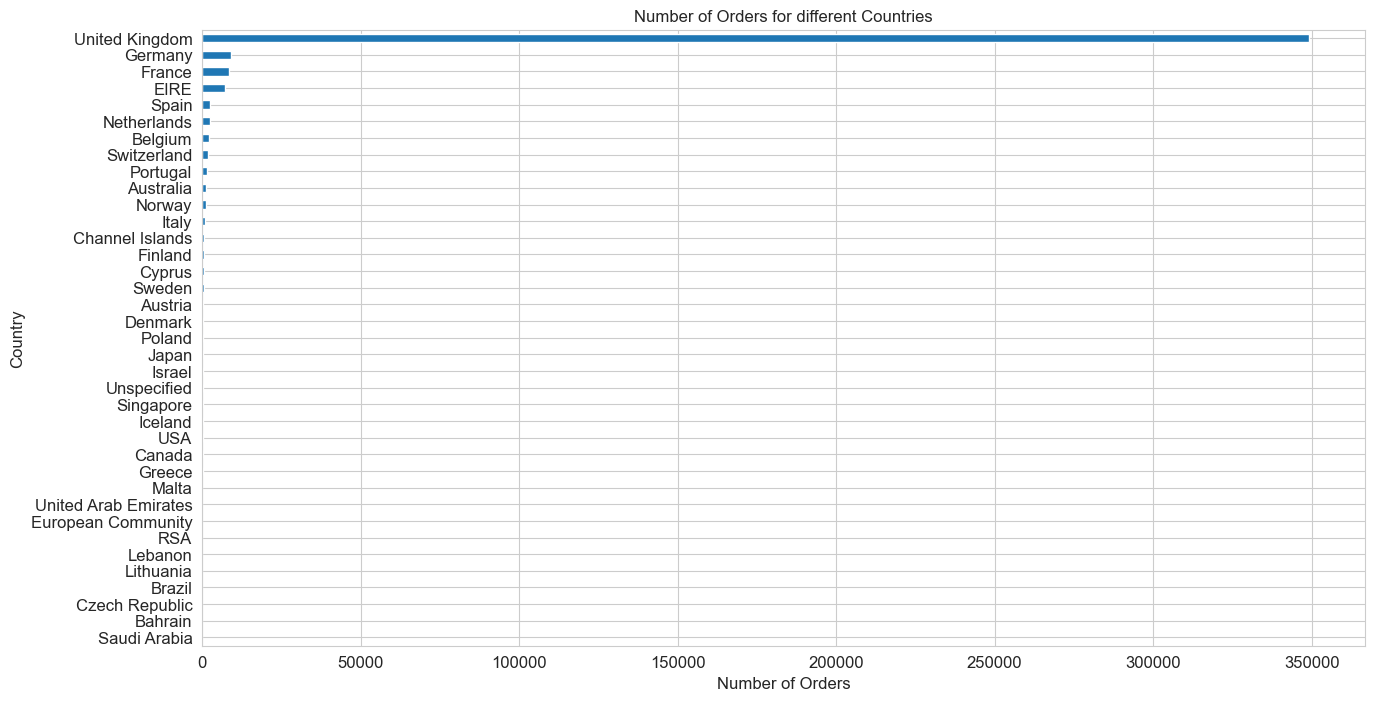

In [62]:
group_country_orders = df_new.groupby('country')['invoice_num'].count().sort_values()
# del group_country_orders['United Kingdom']

# plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12, color=color[0])
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

The company is based in UK, so it seems natural that the country with most sold items is UK. For further analysis, will be focused more on UK so other country will be dropped.

In [63]:
df_new = df_new[df_new['country']=='United Kingdom']

## Sold Product Analysis

In [64]:
df_new.head()

,invoice_num,stock_code,yearmonth,month,day,hour,description,quantity,invoice_date,unit_price,customer_id,country,amount_spent
224385,556519,POST,201106,6,1,10,POSTAGE,1,2011-06-13 10:54:00,2.02,16794,United Kingdom,2.02
152729,549689,POST,201104,4,1,13,POSTAGE,1,2011-04-11 13:40:00,4.95,15971,United Kingdom,4.95
382502,569904,POST,201110,10,4,16,POSTAGE,3,2011-10-06 16:27:00,15.00,13023,United Kingdom,45.00
287076,562047,POST,201108,8,2,10,POSTAGE,1,2011-08-02 10:38:00,4.95,17788,United Kingdom,4.95
286744,562037,POST,201108,8,2,9,POSTAGE,3,2011-08-02 09:34:00,15.00,13023,United Kingdom,45.00


In [65]:
df_new['stock_code'].nunique()

3645

There are 3659 different sold products in the dataset.

## Which products are the most sold?

In [67]:
most_sold_products=df_new.groupby(by=['stock_code','description'])['quantity'].sum().sort_values(ascending=False).iloc[:50]
df_top_prod=most_sold_products.to_frame().reset_index()
df_top_prod.head()

,stock_code,description,quantity
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49086
3,85099B,JUMBO BAG RED RETROSPOT,41878
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34630


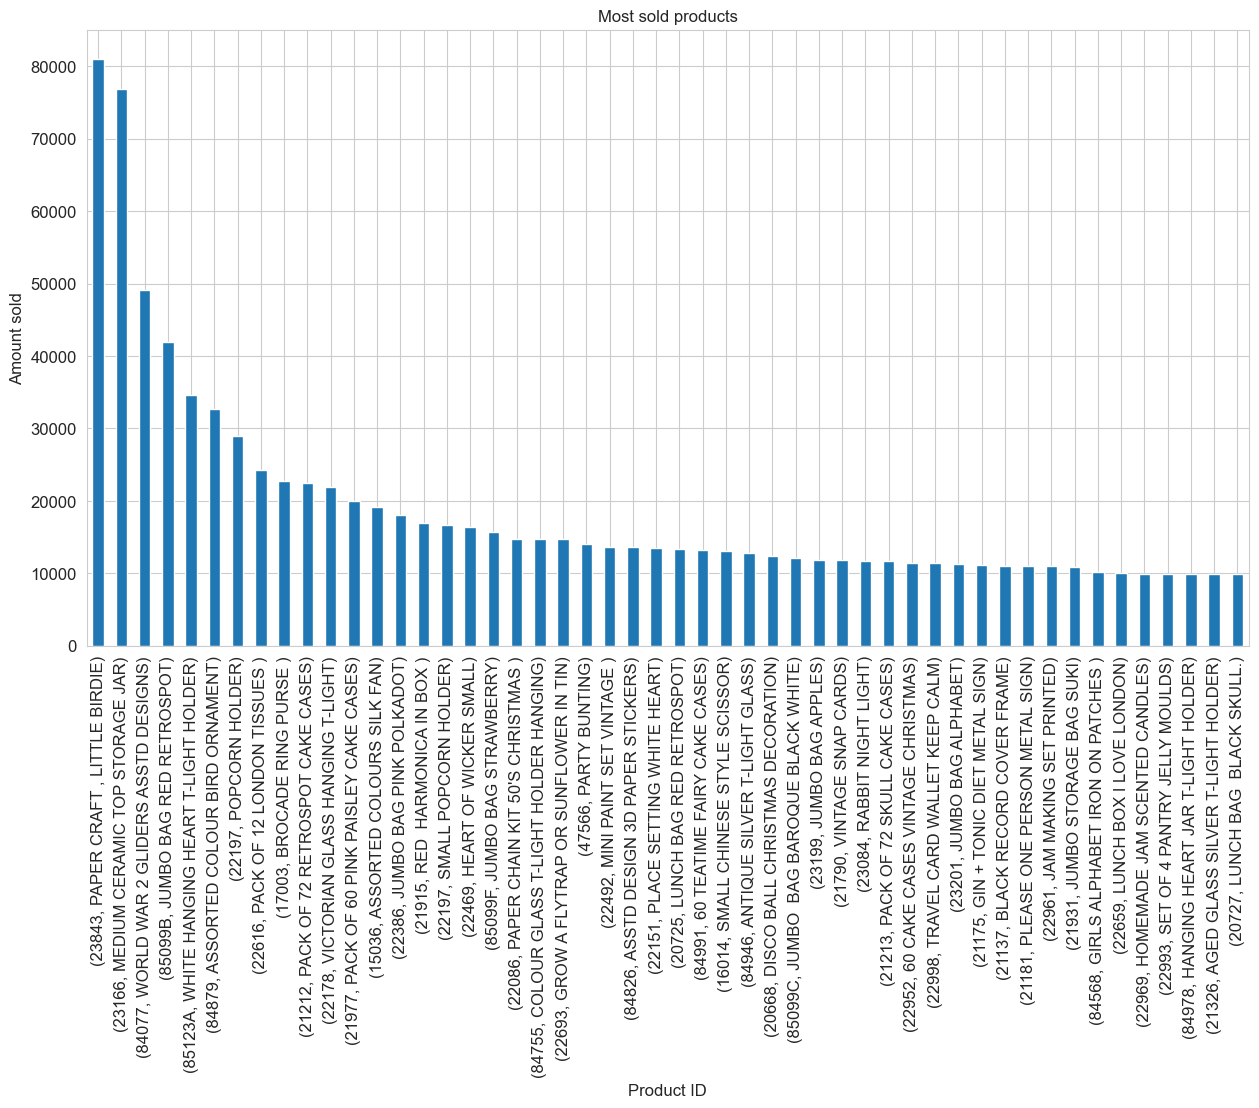

In [68]:
plt.subplots(figsize=(15,8))
most_sold_products.plot(kind='bar', fontsize=12, color=color[0])
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Amount sold', fontsize=12)
plt.title('Most sold products', fontsize=12)
plt.show()

# 6. Customer Segmentation

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

- Recency: The value of how recently a customer purchased at the establishment
- Frequency: How frequent the customer’s transactions are at the establishment
- Monetary value: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

## 6.1 RFM Model for Customer Value :

### 6.1.1 Recency (R)

To calculate recency, we need to choose a date point from which we evaluate how many days ago was the customer's last purchase.

In [72]:
#last date available in our dataset
df_new['invoice_date'].max()

Timestamp('2011-12-09 12:49:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [73]:
now = dt.date(2011,12,9)

#create a new column called date which contains the date of invoice only
df_new['date'] = pd.DatetimeIndex(df_new['invoice_date']).date

#group by customers and check last date of purshace
recency_df = df_new.groupby(by='customer_id', as_index=False)['date'].max()
recency_df.columns = ['customer_id','last_purchase_date']
recency_df.head()

#calculate recency
recency_df['Recency'] = recency_df['last_purchase_date'].apply(lambda x: (now - x).days)

In [74]:
recency_df.head()

,customer_id,last_purchase_date,Recency
0,12346,2011-01-18,325
1,12747,2011-12-07,2
2,12748,2011-12-09,0
3,12749,2011-12-06,3
4,12820,2011-12-06,3


In [76]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('last_purchase_date',axis=1,inplace=True)

<AxesSubplot:xlabel='Recency', ylabel='Density'>

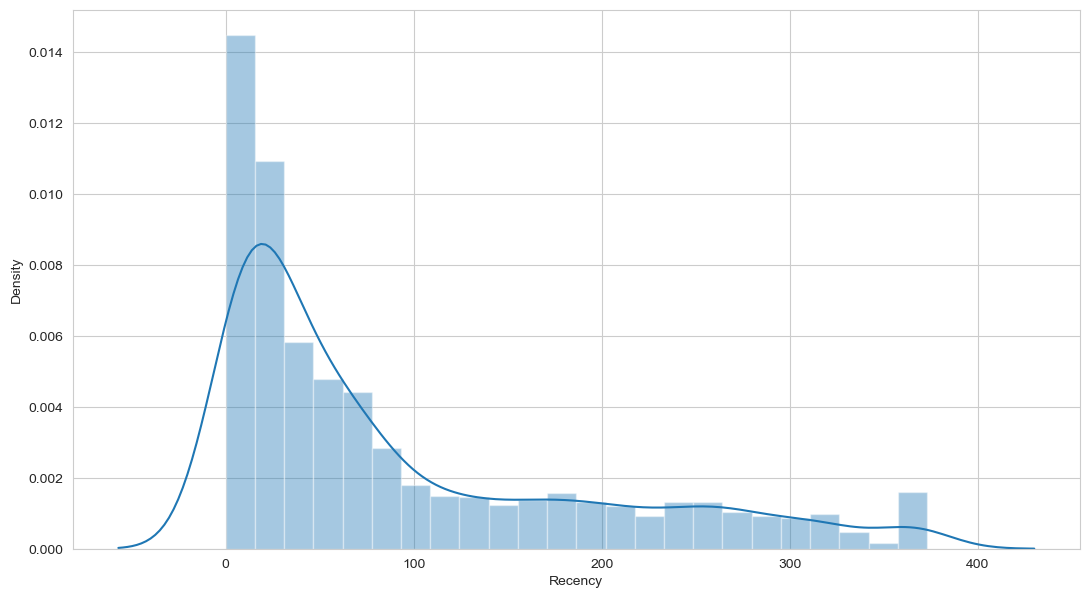

In [77]:
#plot the skewness of recency metric
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(recency_df.Recency)

From the first graph above we can see that sales recency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased

### 6.1.2 Frequency

Frequency helps us to know how many times a customer purchased from us. To do that we need to check how many invoices are registered by the same customer.

In [80]:
# drop duplicates
df_new_copy = df_new.copy()
df_new_copy.drop_duplicates(subset=['invoice_num', 'customer_id'], keep="first", inplace=True)

#calculate frequency of purchases
frequency_df = df_new_copy.groupby(by=['customer_id'], as_index=False)['invoice_num'].count()
frequency_df.columns = ['customer_id','Frequency']
frequency_df.head()

,customer_id,Frequency
0,12346,1
1,12747,11
2,12748,210
3,12749,5
4,12820,4


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

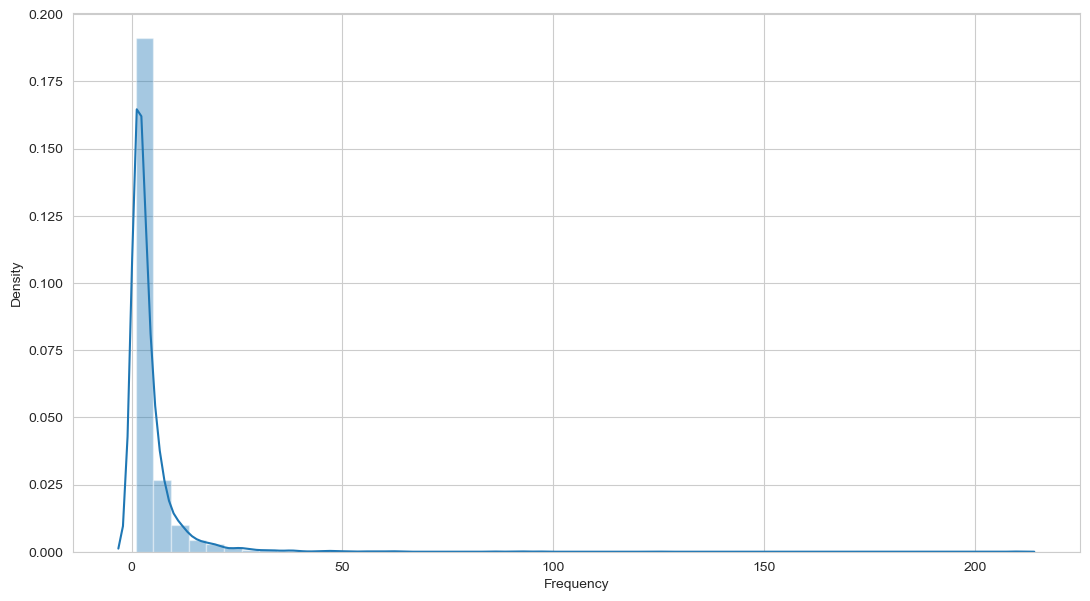

In [81]:
#plot the skewness of frequency metric
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(frequency_df.Frequency)

From the first graph above we can see that sales frequency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

### 6.1.3 Monetary

Monetary attribute answers the question: How much money did the customer spent over time?

To do that, first, we will create a new column total cost to have the total price per invoice.

In [82]:
monetary_df = df_new.groupby(by='customer_id',as_index=False).agg({'amount_spent': 'sum'})
monetary_df.columns = ['customer_id','Monetary']
monetary_df.head()

,customer_id,Monetary
0,12346,77183.60
1,12747,4196.01
2,12748,33053.19
3,12749,4090.88
4,12820,942.34


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

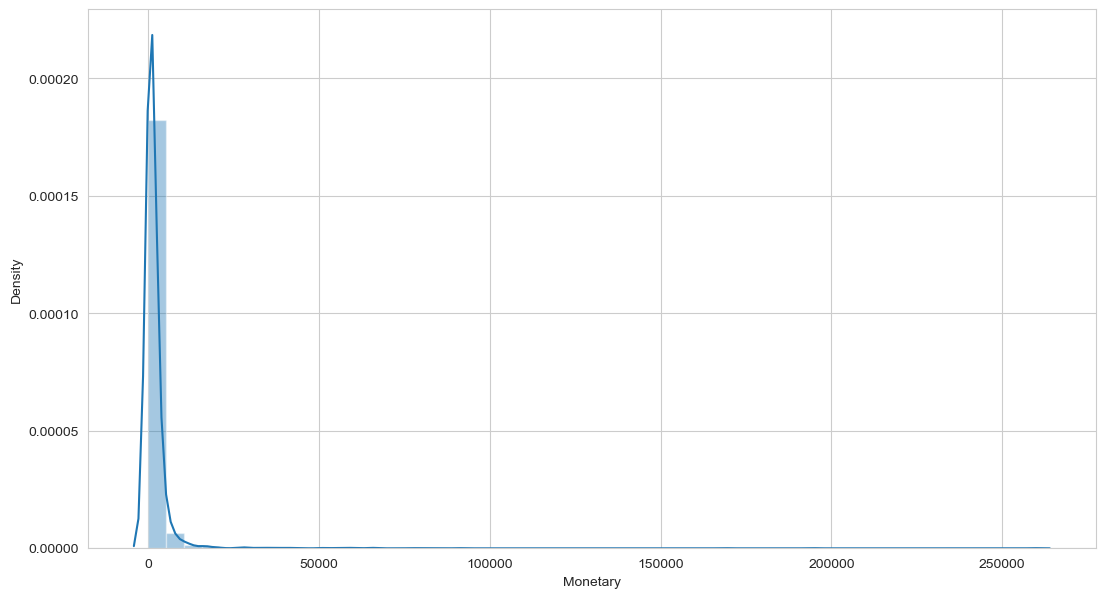

In [83]:
#plot the skewness of monetary metric
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(monetary_df.Monetary)

From the first graph above we can see that sales amount distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased. Later we have to normalize this data.

### 6.1.4 RFM Table

In [85]:
#merge recency dataframe with frequency dataframe
rf_df = recency_df.merge(frequency_df,on='customer_id')
rf_df.head()

,customer_id,Recency,Frequency
0,12346,325,1
1,12747,2,11
2,12748,0,210
3,12749,3,5
4,12820,3,4


In [86]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = rf_df.merge(monetary_df,on='customer_id')
#use CustomerID as index
rfm_df.set_index('customer_id',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
customer_id,,,
12346,325,1,77183.60
12747,2,11,4196.01
12748,0,210,33053.19
12749,3,5,4090.88
12820,3,4,942.34


### 6.1.5 RFM Table Visualization

            Recency  Frequency  Monetary
Recency    1.000000  -0.273779 -0.129116
Frequency -0.273779   1.000000  0.507366
Monetary  -0.129116   0.507366  1.000000


<AxesSubplot:>

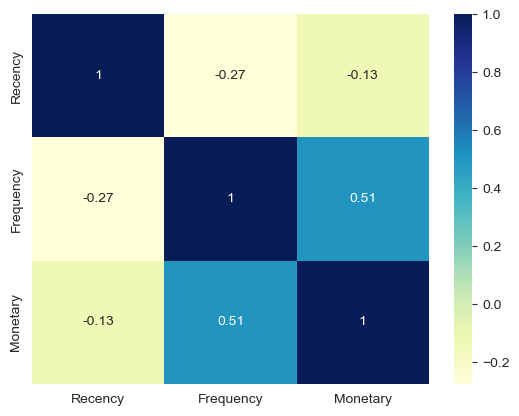

In [87]:
print(rfm_df.corr())
sns.heatmap(rfm_df.corr(),cmap="YlGnBu",annot=True)

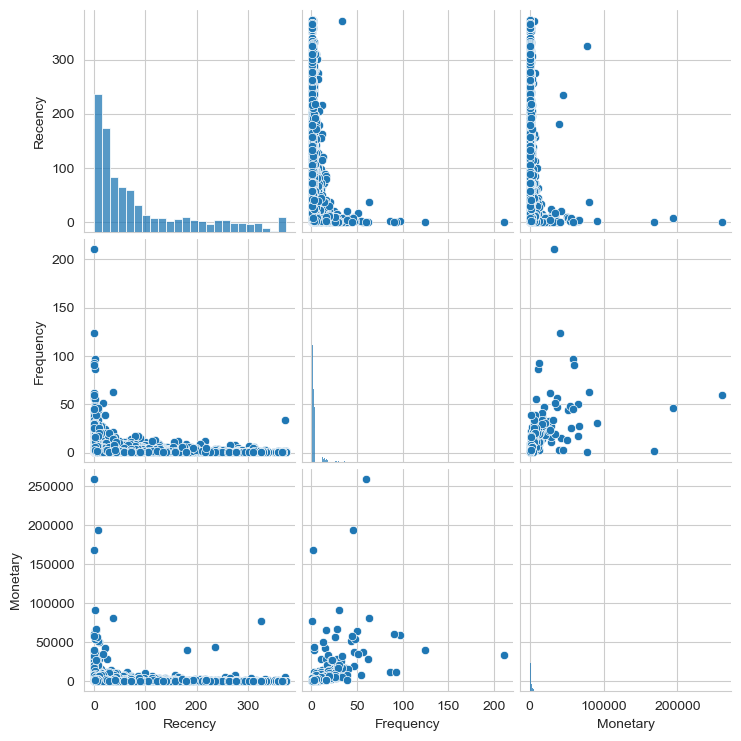

In [88]:
sns.pairplot(rfm_df, diag_kind="hist")

### 6.1.6 RFM Normalization

In [89]:
from sklearn.preprocessing import StandardScaler
feats = ['Recency', 'Frequency', 'Monetary']
X = rfm_df[feats].values
X_std = StandardScaler().fit_transform(X)
rfm_dfs = pd.DataFrame(data=X_std, columns=feats)

In [90]:
rfm_dfs.head()

,Recency,Frequency,Monetary
0,2.344127,-0.450546,10.074607
1,-0.901588,0.937411,0.312709
2,-0.921685,28.557767,4.172281
3,-0.891539,0.104637,0.298648
4,-0.891539,-0.034159,-0.122461


## 6.2 Clustering for Segments with K-Means

### 6.2.1 The Elbow Method

In [91]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X_std)
  nilai_inertia = kmeans.inertia_
  print('iterasi ke-',i, 'dengan nilai inertia : ',nilai_inertia)
  inertia.append(kmeans.inertia_)

iterasi ke- 2 dengan nilai inertia :  8364.780816872566
iterasi ke- 3 dengan nilai inertia :  5116.87948170118
iterasi ke- 4 dengan nilai inertia :  3793.1407445862583
iterasi ke- 5 dengan nilai inertia :  2762.7380477067595
iterasi ke- 6 dengan nilai inertia :  2214.0180911390917
iterasi ke- 7 dengan nilai inertia :  1808.1727878903696
iterasi ke- 8 dengan nilai inertia :  1496.1581713610617
iterasi ke- 9 dengan nilai inertia :  1288.459495873911
iterasi ke- 10 dengan nilai inertia :  1147.4776140331471


Text(0, 0.5, 'Distortion Score')

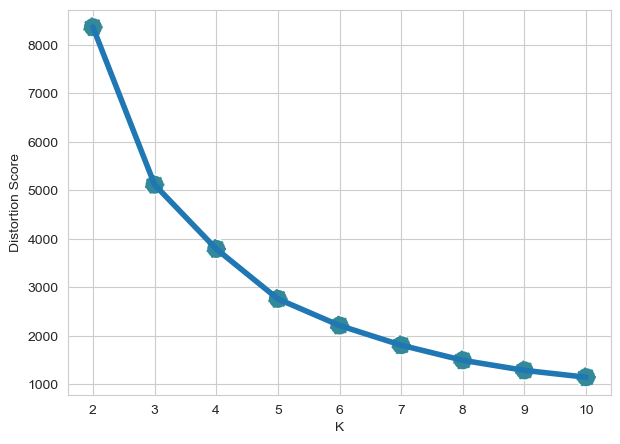

In [92]:
plt.figure(figsize=(7, 5))

sns.lineplot(x=range(2, 11), y=inertia, linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=200, color='#389',  linestyle='--')
plt.xlabel("K")
plt.ylabel("Distortion Score")

**Insights**

Note that by the Elbow method from a K equal to 3 we already observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10% with the K equal to 5. With this in mind, we will begin to evaluate the options more deeply with 3, 4 and 5, starting with the silhouette analysis.

### 6.2.2 Silhoutte Analysis

In [112]:
for num in range(2,16):
    clusters = KMeans(n_clusters=num,random_state=0)
    labels = clusters.fit_predict(rfm_dfs)
    
    sil_avg = silhouette_score(rfm_dfs, labels)
    print('For',num,'The Silhouette Score is =',sil_avg)

For 2 The Silhouette Score is = 0.6345993824975169
For 3 The Silhouette Score is = 0.6630055803154571
For 4 The Silhouette Score is = 0.6748465594195759
For 5 The Silhouette Score is = 0.6565111730518468
For 6 The Silhouette Score is = 0.6509448569062669
For 7 The Silhouette Score is = 0.5730934650261901
For 8 The Silhouette Score is = 0.5062789839081041
For 9 The Silhouette Score is = 0.42541582669028843
For 10 The Silhouette Score is = 0.4277882943566352
For 11 The Silhouette Score is = 0.44784778214680676
For 12 The Silhouette Score is = 0.4492596002292663
For 13 The Silhouette Score is = 0.44835315803388176
For 14 The Silhouette Score is = 0.4243261038165636
For 15 The Silhouette Score is = 0.412934173846943


**Insights**

When we look at the results of the clustering process, we can infer some interesting insights:

- First notice that **K = 5 obtain the lowest silhoutte score**, so we're gonna eliminate this one from our options.
- In the other hand, all options had a some wide fluctuations in the size of the silhouette plots.
- So, the best choice may lie on the option that gives us a simpler business explanation and at the same time target customers in focus groups with sizes closer to the desired.

### 6.2.3 Cluster Insights & Analysis

In [94]:
from sklearn.cluster import KMeans

#3 cluster
kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(X_std)

KMeans(n_clusters=3, random_state=0)

In [95]:
#4 cluster
kmeans4 = KMeans(n_clusters=4, random_state=0)
kmeans4.fit(X_std)

KMeans(n_clusters=4, random_state=0)

In [96]:
#adding cluster to scaled datasets
rfm_dfs['cluster_4'] = kmeans4.labels_
rfm_dfs['cluster_3'] = kmeans3.labels_

#adding cluster to unscaled datasets
rfm_df['cluster_4'] = kmeans4.labels_
rfm_df['cluster_3'] = kmeans3.labels_

In [97]:
rfm_dfs.head()

,Recency,Frequency,Monetary,cluster_4,cluster_3
0,2.344127,-0.450546,10.074607,3,2
1,-0.901588,0.937411,0.312709,1,1
2,-0.921685,28.557767,4.172281,3,2
3,-0.891539,0.104637,0.298648,1,1
4,-0.891539,-0.034159,-0.122461,1,1


#### 6.2.3.1 Cluster Insights

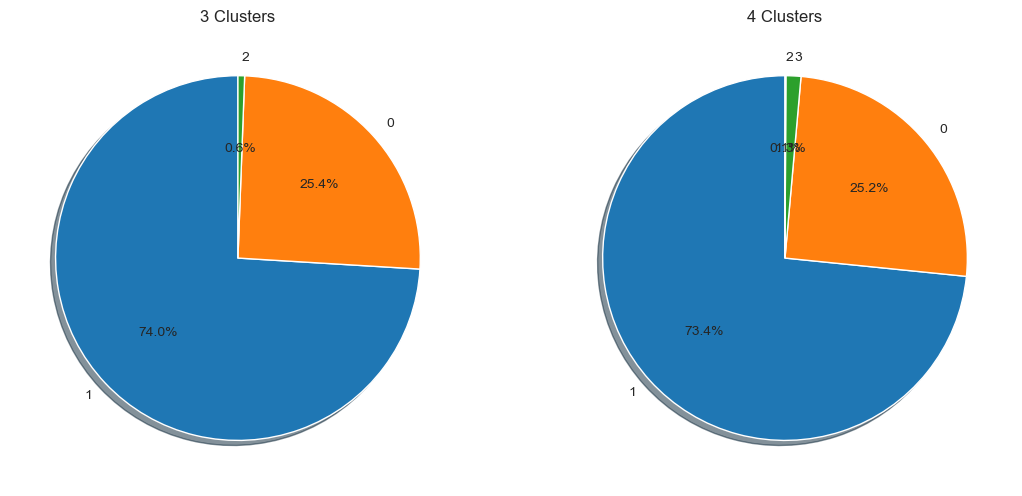

In [99]:
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = rfm_df.cluster_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = rfm_df.cluster_4.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('4 Clusters')
plt.show()

**Insights:** 

From the chart above we can see that in both clusters, the percentage of each cluster is similiar. But in 4 Clusters case, we have another cluster with a very small percentage 0.2%.
This is going to need further analysis to see if this 0.2% make a significant difference in the segmentation.

In [100]:
display(rfm_df.groupby('cluster_3').agg(['mean','median']))

Recency         Frequency             Monetary            \
                 mean median       mean median          mean    median   
cluster_3                                                                
0          243.407035  239.0   1.589950    1.0    485.900594    305.75   
1           40.310369   30.0   4.715122    3.0   1777.104279    882.72   
2           18.782609    3.0  59.956522   50.0  71418.253478  58510.48   

          cluster_4         
               mean median  
cluster_3                   
0          0.008040    0.0  
1          1.021702    1.0  
2          2.869565    3.0

**Insights from 3 Clusters**

- The tree clusters appears have a good stark differences in the Monetary value of the customer.
- Cluster 0 **the Champion** : is the cluster of high value customer who shops frequently and is certainly an important segment for each business. Reward these customers. They can become early adopters for new products and will help promote your brand.
- Cluster 1 is **Hibernating** : Hibernating customers are customers who purchased a long time ago and who spent average amount and of course the recency will be high. It could be occasional because of birthday, holiday or any other occasion. This is the hardest one to engage. This clusters require further personalization, for example if this customer purchased for birthday, we can make birthday campaign and give them discount or bundling deals. We need to reactivate this customer or otherwise we're at risk losing them.  Send personal emails and messages to reconnect. Provide helpful resources. 
- Cluster 2 is **Promising** : Promising are customers who have average RFM value, they spend average amount, their purchase not that often, they also have relatively average recency. This segment of customer can be maximize to drive more revenue. Offer subscription and loyalty programs. Provide recommendations. Ask for reviews. Send gifts, handwritten cards, etc. Make one-on-one personalized phone calls.

In [101]:
display(rfm_df.groupby('cluster_4').agg(['mean','median']))

Recency         Frequency              Monetary              \
                 mean median       mean median           mean      median   
cluster_4                                                                   
0          244.197368  239.5   1.589069    1.0     524.180426     305.765   
1           40.919041   30.0   4.410354    3.0    1572.538396     865.650   
2            2.666667    0.0  36.000000   46.0  207506.863333  194390.790   
3           11.596154    3.0  43.807692   34.5   31131.697885   26301.980   

          cluster_3         
               mean median  
cluster_4                   
0          0.001012    0.0  
1          0.997220    1.0  
2          2.000000    2.0  
3          1.384615    1.0

**Insights :**
- Cluster 0 is **Promising** : Promising are customers who have average RFM value, they spend average amount, their purchase not that often, they also have relatively average recency. This segment of customer can be maximize to drive more revenue. Offer subscription and loyalty programs. Provide recommendations. Ask for reviews. Send gifts, handwritten cards, etc. Make one-on-one personalized phone calls.
- Cluster 1 is **Hibernating**: Hibernating customers are customers who purchased a long time ago and who spent average amount and of course the recency will be high. It could be occasional because of birthday, holiday or any other occasion. This is the hardest one to engage. This clusters require further personalization, for example if this customer purchased for birthday, we can make birthday campaign and give them discount or bundling deals. We need to reactivate this customer or otherwise we're at risk losing them.  Send personal emails and messages to reconnect. Provide helpful resources.
- Cluster 2 is the **Champion** : Champions are the best customers, who bought most recently, most often, and are heavy spenders. This cluster is the smallest portion of the total customers, so we can't lose them. Reward these customers. They can become early adopters for new products and will help promote your brand.
- Cluster 3 is the **Potential Loyalist** : Potential Loyalists are your recent customers with average frequency and who spent a good amount. They're 7% of the total customers, if we can make them champion, it will increase our revenue significantly. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.

**Insights From 3 and 4 Clusters** 

- It could be seen that the 0,6% Champion is needed in this segmentation, so we could personalize more the campaign and we could take different approch for eachs segments.
- From this analysis, 4 Clusters Segmentation suits more in terms of business explanations and we're gonna use it.

#### 6.2.3.2 Cluster Visualization

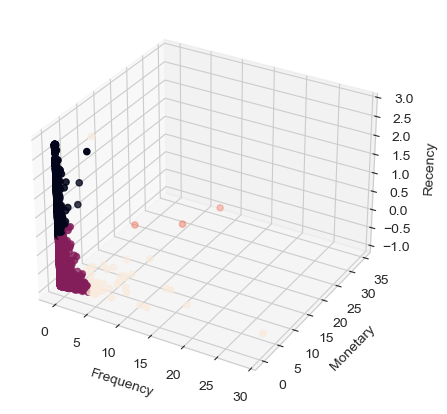

In [102]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata = rfm_dfs.Recency
xdata = rfm_dfs.Frequency
ydata = rfm_dfs.Monetary
cdata = rfm_dfs.cluster_4
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
ax.scatter3D(xdata, ydata, zdata, c=cdata)

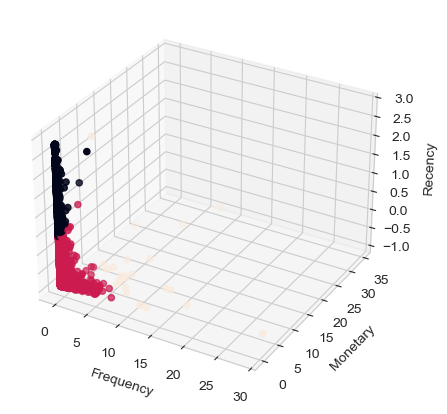

In [103]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata = rfm_dfs.Recency
xdata = rfm_dfs.Frequency
ydata = rfm_dfs.Monetary
cdata = rfm_dfs.cluster_3
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
ax.scatter3D(xdata, ydata, zdata, c=cdata)